In [1]:
%matplotlib inline

In [1]:
# The code in this file makes use of Code written by Dr Abdulrahman Altahhan
#for the Robotics Module at the University fo Leeds

In [ ]:
import rclpy as ros
from rclpy.node import Node

from geometry_msgs.msg import Twist
from nav_msgs.msg import Odometry
from sensor_msgs.msg import LaserScan
from std_srvs.srv import Empty

import numpy as np
from numpy import Inf
from random import randint
from math import atan2, pi
import matplotlib.pyplot as plt

## Moving the robot(Actions)
We start by controlling the robot only

Go to /opt/ros/humble/share/turtlebot3_gazebo/models/turtlebot3_burger/model.sdf and adjust the <update_rate>30</update_rate> to <update_rate>5</update_rate> for the odomotry turtlebot3_diff_drive. This will change its frequency from 30 to 5 so that it aligns with the scanner frequency.

In [ ]:
def name(): return 'node'+str(randint(1,1000))

In [ ]:
class Env(Node):

# initialisation--------------------------------------------------------------
    # frequency: how many often (in seconds) the spin_once is invoked, or the publisher is publishing to the /cmd_vel
    def __init__(self, name=name(),
                 freq=1/20, n=28,
                 speed=.6, θspeed=pi/2,
                 rewards=[10, -10, 0, -1],
                 verbose=False):
        super().__init__(name)

        self.freq = freq
        self.n = n

        self.speed = speed
        self.θspeed = round(θspeed,2)

        self.robot = Twist()
        self.rewards = rewards
        self.verbose = verbose

        # do not change----------------------------------------------------
        self.x = 0 # initial x position
        self.y = 0 # initial y position
        self.θ = 0 # initial θ angle
        self.scans = np.zeros(60) # change to how many beams you are using
        self.t = 0

        self.tol = .5  # meter from goal as per the requirement (tolerance)
        self.goals =  [[2.0, 2.0], [-2.0, -2.0]]
        # -----------------------------------------------------------------

        self.controller = self.create_publisher(Twist, '/cmd_vel', 0)
        self.timer = self.create_timer(self.freq, self.control)

        self.scanner = self.create_subscription( LaserScan, '/scan', self.scan, 0)
        self.odometr = self.create_subscription( Odometry, '/odom', self.odom, 0)

        self.range_max = 3.5
        self.range_min = .28               # change as you see fit .25 or .30 , anythng beyond is treated as infinite?
        # self.θresol = round(2*pi/8, 2)   # dividing a turning circle into sectors

        # establish a reset client
        self.reset_world = self.create_client(Empty, '/reset_world')
        while not self.reset_world.wait_for_service(timeout_sec=2.0):
            print('world client service...')


        # compatibility----------------------------------------------
        resol = .3  # change to .5, this is the grid size.
        θresol = 2*pi/8
        dims = [4,4]
        self.xdim = dims[0]  # realted to the size of the environment
        self.ydim = dims[1]  # realted to the size of the environment

        self.resol = round(resol,2)
        self.θresol = round(θresol,2)

        self.cols  = int(self.xdim//self.resol) +1   # number of grid columns, related to linear speed
        self.rows  = int(self.ydim//self.resol) +1   # number of grid rows,    related to linear speed
        self.orts  = int(2*pi//self.θresol)     +1   # number of angles,       related to angular speed

        self.nC = self.rows*self.cols              # Grid size
        self.nS = self.rows*self.cols*self.orts # State space size
        self.nA = 3 # you can change this as well, anything after the robot does not recognise ?


        self.Vstar = None # for compatibility
        # ---------------------------------------------------------------
        # self.rate = self.create_rate(30)
        self.reset()

        print('speed  = ', self.speed)
        print('θspeed = ', self.θspeed)
        print('freq   = ', self.freq)

# sensing--------------------------------------------------------------
    # odometry (position and orientation) readings
    def odom(self, odoms):
        self.x = round(odoms.pose.pose.position.x, 1)
        self.y = round(odoms.pose.pose.position.y, 1)
        self.θ = round(self.yaw(odoms.pose.pose.orientation),2)
        self.odom = np.array([self.x, self.y, self.θ])
        if self.verbose: print('odom = ',  self.odom )

    # laser scanners readings
    def scan(self, scans):
        self.scans = np.array(scans.ranges)
        self.scans[scans==Inf] = self.range_max
        if self.verbose: print('scan = ', self.scans[:10].round(2))


        #improved the scan reading code, Handling Near Infinite Values: Sometimes, very large values, though not infinite, can also skew the data. Consider capping all values at self.range_max
    def scan(self, scans):
    self.scans = np.minimum(self.scans, self.range_max)
    # Replace infinite values with the maximum range of the laser scanner
    self.scans[self.scans == np.inf] = self.range_max
    if self.verbose:
        print('scan = ', self.scans[:10].round(2))


    # converting to the quaternion self.z to Euler
    # see https://www.allaboutcircuits.com/technical-articles/dont-get-lost-in-deep-space-understanding-quaternions/#
    # see https://eater.net/quaternions/video/intro

    def yaw(self, orient):
        x, y, z, w = orient.x, orient.y, orient.z, orient.w
        yaw = atan2(2.0*(x*y + w*z), w*w + x*x - y*y - z*z)
        return yaw if yaw>0 else yaw + 2*pi # in radians, [0, 2pi]

    # angular distance of robot to a goal.............................................
    def θgoal(self, goal):
        xgoal, ygoal = self.goals[goal]
        x, y  = self.x, self.y
        θgoal = atan2(abs(xgoal-x), abs(ygoal-y)) # anglegoal
        # if θgoal<=0  θgoal += 2*pi
        return round(θgoal, 2) # in radians, [0, 2pi]

from math import atan2, pi

#improved, we introduce Angle Normalization for negative angles
#These modifications will make the function more robust and accurate, ensuring that the angular distance to the goal is correctly calculated
#regardless of the relative positions of the robot and the goal.

def θgoal(self, goal):
    xgoal, ygoal = self.goals[goal]
    x, y = self.x, self.y
    angle = atan2(ygoal - y, xgoal - x)  # Correct order and no abs, maintains direction information
    if angle < 0:
        angle += 2 * pi  # Normalize angle to be in the range [0, 2*pi]
    return round(angle, 2)


    # Eucleadian distance of robot to nearest goal......................................
    def distgoal(self):
        dists = [Inf, Inf]        # distances of robot to the two goals
        for goal, (xgoal, ygoal) in enumerate(self.goals):
            dists[goal] = (self.x - xgoal)**2 + (self.y - ygoal)**2

        dist = min(dists)         # nearest goal distance
        goal = dists.index(dist)  # nearest goal index

        if self.verbose: print('seeking goal ____________________', goal)
        return round(dist**.5, 2), goal

    # robot reached goal ...............................................................
    def atgoal(self):
        tol, x, y = self.tol,  self.x, self.y
        atgoal = False
        for xgoal, ygoal in self.goals:
            atgoal = xgoal + tol > x > xgoal - tol  and  \
                     ygoal + tol > y > ygoal - tol

            if atgoal: print('Goal has been reached woohoooooooooooooooooooooooooooooo!!'); break
        return atgoal

      # Improved version simplifies the check within the loop and directly returns True when the goal conditions are met

    def atgoal(self):
    tol, x, y = self.tol, self.x, self.y
    for xgoal, ygoal in self.goals:
        if (xgoal - tol < x < xgoal + tol) and (ygoal - tol < y < ygoal + tol):
            print('Goal has been reached woohoooooooooooooooooooooooooooooo!!')
            return True
    return False


    # robot hits a wall...................................................................
    def atwall(self, rng=4): # experiment to see if changing this is useful or not
        #By using rng=4, the code is designed to check the 4 scan points on the extreme left and 4 scan points on the extreme right of the robot’s frontal scanner array.
        # check only 2*rng front scans for collision, given the robot does not move backward
        return np.r_[self.scans[-rng:], self.scans[:rng]].min() < self.range_min
        #return self.scans.min()<self.range_min

    # reward function to produce a suitable policy..........................................
    def reward(self, a, imp=2):
        stype = [self.atgoal(), self.atwall(), a==1, a!=1].index(True)

        dist, goal = self.distgoal()
        θgoal = self.θgoal(goal)

        # get angular distance to reward/penalise robot relative to its orientation towards a goal
        θdist = abs(self.θ - θgoal)
        if goal==1: θdist -= pi
        θdist = round(abs(θdist),2)

        reward = self.rewards[stype]
        if stype: reward -= imp*(dist+θdist)

        if self.verbose:
            print('reward components=',
                  'Total reward=', reward,
                  'state reward=', self.rewards[stype],
                  'goal dist=', dist,
                  '|θ-θgoal|=', θdist)
                #   'θrobot=', self.θ,
                #   'θgoal =', θgoal,

        # reset without restarting an episode if the robot hits a wall
        if stype==1: self.reset()

        return reward, stype==0, stype==1

# State representation-------------------------------------------------
   # change this to generate a suitable state representation
    def s_(self):

        self.xi = int((self.x+self.xdim/2)//self.resol)     # x index = col, assuming the grid middle is (0,0)
        self.yi = int((self.y+self.ydim/2)//self.resol)     # y index = row, assuming the grid middle is (0,0)

        # pi/2 to be superficially resilient to slight angle variation to keep θi unchanged
        self.θi = int((self.θ+pi/2)%(2*pi)//self.θresol)

        self.si = self.xi + self.yi*self.cols     # position state in the grid
        self.s = self.nC*(self.θi) + self.si      # position state with orientation
        if self.verbose: print('grid cell= ', self.si, 'state = ', self.s)
        return self.s


# Control--------------------------------------------------------------
    def spin_n(self, n):
        for _ in range(n): ros.spin_once(self)

    def control(self):
        self.controller.publish(self.robot)

    # move then stop to get a defined action
    def step(self, a=1, speed=None, θspeed=None):
        if speed is None: speed = self.speed
        if θspeed is None: θspeed = self.θspeed

        self.t +=1
        if self.verbose: print('step = ', self.t)


        #here you can provide more actions if you see suitable in the +ve
        if  a==-1: self.robot.linear.x  = -speed  # backwards
        elif a==1: self.robot.linear.x  =  speed  # forwards
        elif a==0: self.robot.angular.z =  θspeed # turn left
        elif a==2: self.robot.angular.z = -θspeed # turn right



        # Now move and stop so that we can have a well defined actions
        self.spin_n(self.n) if a==1 else self.spin_n(self.n//2)
        self.stop()

        reward, done, wall = self.reward(a)
        return self.s_(), reward, done, {}

    def stop(self):
        self.robot.linear.x = .0
        self.robot.angular.z = .0
        #  spin less so that we have smoother actions
        self.spin_n(self.n//8)

# reseting-------------------------------------------------------------- make sure to get up to date odom and scan
    def reset(self):
        print('resetting world..........................................')
        # to ensure earlier queued actions are flushed, there are better ways to do this
        for _ in range(1): self.reset_world.call_async(Empty.Request())
        for _ in range(2): self.step(a=1, speed=0.001)  # move slightly forward to update the odometry to prevent repeating an episode unnecessary
        for _ in range(1): self.reset_world.call_async(Empty.Request())

        return self.s_()

    # for compatibility, no need to change
    def render(self, **kw):
        pass

class TileCoding:
    def __init__(self, num_tiles, state_bounds, num_tilings):
        self.num_tiles = num_tiles  
        self.state_bounds = state_bounds  
        self.num_tilings = num_tilings  

    def encode(self, state):
        tile_indices = []
        for dim in range(len(state)):
            state_min, state_max = self.state_bounds[dim]
            tile_width = (state_max - state_min) / self.num_tiles
            for tiling in range(self.num_tilings):
                offset = (tile_width / self.num_tilings) * tiling 
                index = int((state[dim] - state_min + offset) / tile_width)
                tile_indices.append(index)
        return np.array(tile_indices)

In [ ]:
import matplotlib.pyplot as plt
from math import atan2, pi
import numpy as np
from geometry_msgs.msg import Twist
from nav_msgs.msg import Odometry
from sensor_msgs.msg import LaserScan
from std_srvs.srv import Empty
import rclpy as ros
from rclpy.node import Node

class Env(Node):
    def __init__(self, name=name(), freq=1/20, n=28, speed=.6, θspeed=pi/2, rewards=[10, -10, 0, -1], verbose=False):
        super().__init__(name)
        self.freq = freq
        self.n = n
        self.speed = speed
        self.θspeed = round(θspeed, 2)
        self.robot = Twist()
        self.rewards = rewards
        self.verbose = verbose

        self.scans = np.zeros(60)  # Default laser scan array

        self.controller = self.create_publisher(Twist, '/cmd_vel', 10)
        self.timer = self.create_timer(self.freq, self.control)
        self.scanner = self.create_subscription(LaserScan, '/scan', self.scan, 10)
        self.reset_world = self.create_client(Empty, '/reset_world')

    def scan(self, msg):
        self.scans = np.array(msg.ranges)
        if self.verbose:
            print("scan =", self.scans[:10].round(2))

    def s_(self):
        laser_data = self.scans[:self.n]
        return np.array(laser_data)

    def reset(self):
        print("Resetting...")
        self.reset_world.call_async(Empty.Request())
        return self.s_()

    def reward(self, action):
        collision = self.atwall()
        reached_goal = False  

        reward = -1 
        if reached_goal:
            reward += 400  
        if collision:
            reward -= 10  
        return reward, reached_goal, collision

    def plot_sensor_data(self):
        angles = np.linspace(-pi, pi, len(self.scans))
        plt.figure(figsize=(8, 4))
        plt.polar(angles, self.scans)
        plt.title("Laser Scan Data")
        plt.show()


    def yaw(self, orient):
        x, y, z, w = orient.x, orient.y, orient.z, orient.w
        yaw = atan2(2.0*(x*y + w*z), w*w + x*x - y*y - z*z)
        return yaw if yaw>0 else yaw + 2*pi # in radians, [0, 2pi]

    # angular distance of robot to a goal.............................................
    def θgoal(self, goal):
        xgoal, ygoal = self.goals[goal]
        x, y  = self.x, self.y
        θgoal = atan2(abs(xgoal-x), abs(ygoal-y)) # anglegoal
        # if θgoal<=0  θgoal += 2*pi
        return round(θgoal, 2) # in radians, [0, 2pi]


    def distgoal(self):
        dists = [Inf, Inf]        # distances of robot to the two goals
        for goal, (xgoal, ygoal) in enumerate(self.goals):
            dists[goal] = (self.x - xgoal)**2 + (self.y - ygoal)**2

        dist = min(dists)         # nearest goal distance
        goal = dists.index(dist)  # nearest goal index

        if self.verbose: print('seeking goal ____________________', goal)
        return round(dist**.5, 2), goal

    # robot reached goal ...............................................................
    def atgoal(self):
        tol, x, y = self.tol,  self.x, self.y
        atgoal = False
        for xgoal, ygoal in self.goals:
            atgoal = xgoal + tol > x > xgoal - tol  and  \
                     ygoal + tol > y > ygoal - tol

            if atgoal: print('Goal has been reached woohoooooooooooooooooooooooooooooo!!'); break
        return atgoal


    def atwall(self, rng=4): # experiment to see if changing this is useful or not
        #By using rng=4, the code is designed to check the 4 scan points on the extreme left and 4 scan points on the extreme right of the robot’s frontal scanner array.
        # check only 2*rng front scans for collision, given the robot does not move backward
        return np.r_[self.scans[-rng:], self.scans[:rng]].min() < self.range_min
        #return self.scans.min()<self.range_min

    # reward function to produce a suitable policy..........................................
    def reward(self, a, imp=2):
        stype = [self.atgoal(), self.atwall(), a==1, a!=1].index(True)

        dist, goal = self.distgoal()
        θgoal = self.θgoal(goal)

        # get angular distance to reward/penalise robot relative to its orientation towards a goal
        θdist = abs(self.θ - θgoal)
        if goal==1: θdist -= pi
        θdist = round(abs(θdist),2)

        reward = self.rewards[stype]
        if stype: reward -= imp*(dist+θdist)

        if self.verbose:
            print('reward components=',
                  'Total reward=', reward,
                  'state reward=', self.rewards[stype],
                  'goal dist=', dist,
                  '|θ-θgoal|=', θdist)
                #   'θrobot=', self.θ,
                #   'θgoal =', θgoal,

        # reset without restarting an episode if the robot hits a wall
        if stype==1: self.reset()

        return reward, stype==0, stype==1

# State representation-------------------------------------------------
   # change this to generate a suitable state representation
    def s_(self):

        self.xi = int((self.x+self.xdim/2)//self.resol)     # x index = col, assuming the grid middle is (0,0)
        self.yi = int((self.y+self.ydim/2)//self.resol)     # y index = row, assuming the grid middle is (0,0)

        # pi/2 to be superficially resilient to slight angle variation to keep θi unchanged
        self.θi = int((self.θ+pi/2)%(2*pi)//self.θresol)

        self.si = self.xi + self.yi*self.cols     # position state in the grid
        self.s = self.nC*(self.θi) + self.si      # position state with orientation
        if self.verbose: print('grid cell= ', self.si, 'state = ', self.s)
        return self.s


# Control--------------------------------------------------------------
    def spin_n(self, n):
        for _ in range(n): ros.spin_once(self)

    def control(self):
        self.controller.publish(self.robot)

    # move then stop to get a defined action
    def step(self, a=1, speed=None, θspeed=None):
        if speed is None: speed = self.speed
        if θspeed is None: θspeed = self.θspeed

        self.t +=1
        if self.verbose: print('step = ', self.t)


        #here you can provide more actions if you see suitable in the +ve
        if  a==-1: self.robot.linear.x  = -speed  # backwards
        elif a==1: self.robot.linear.x  =  speed  # forwards
        elif a==0: self.robot.angular.z =  θspeed # turn left
        elif a==2: self.robot.angular.z = -θspeed # turn right



        # Now move and stop so that we can have a well defined actions
        self.spin_n(self.n) if a==1 else self.spin_n(self.n//2)
        self.stop()

        reward, done, wall = self.reward(a)
        return self.s_(), reward, done, {}

    def stop(self):
        self.robot.linear.x = .0
        self.robot.angular.z = .0
        #  spin less so that we have smoother actions
        self.spin_n(self.n//8)

# reseting-------------------------------------------------------------- make sure to get up to date odom and scan
    def reset(self):
        print('resetting world..........................................')
        # to ensure earlier queued actions are flushed, there are better ways to do this
        for _ in range(1): self.reset_world.call_async(Empty.Request())
        for _ in range(2): self.step(a=1, speed=0.001)  # move slightly forward to update the odometry to prevent repeating an episode unnecessary
        for _ in range(1): self.reset_world.call_async(Empty.Request())

        return self.s_()

    # for compatibility, no need to change
    def render(self, **kw):
        pass


class ActorCritic(MDP):
    def __init__(self, env, alpha=0.001, gamma=0.99, lambda_=0.1, **kw):
        super().__init__(env=env, **kw)
        self.alpha = alpha  
        self.gamma = gamma  
        self.lambda_ = lambda_  
        self.create_models()  
    
    def create_models(self):
        critic_input = Input(shape=(self.env.state_space_size,))
        critic_hidden = Dense(24, activation='relu')(critic_input)
        critic_output = Dense(1)(critic_hidden)  
        self.critic = Model(critic_input, critic_output)
        self.critic.compile(Adam(lr=self.alpha), loss='mse')
        
        actor_input = Input(shape=(self.env.state_space_size,))
        actor_hidden = Dense(24, activation='relu')(actor_input)
        actor_output = Dense(self.env.action_space_size, activation='softmax')(actor_hidden)  
        self.actor = Model(actor_input, actor_output)
        self.actor.compile(Adam(lr=self.alpha))
    
    def select_action(self, state):
        probabilities = self.actor.predict(state[np.newaxis, :])
        return np.random.choice(self.env.action_space_size, p=probabilities[0])  
    
    def update(self, state, action, reward, next_state, done):
        target = reward + (1 - done) * self.gamma * self.critic.predict(next_state[np.newaxis, :])
        
        td_error = target - self.critic.predict(state[np.newaxis, :])
        self.critic.fit(state[np.newaxis, :], target, verbose=0)
        action_probs = self.actor.predict(state[np.newaxis, :])[0]
        gradients = np.zeros(self.env.action_space_size)
        gradients[action] = 1
        self.actor.fit(
            state[np.newaxis, :],
            gradients * td_error,
            verbose=0,
        )

import numpy as np
import matplotlib.pyplot as plt

# Define the environment
class TileEnv:
    def __init__(self):
        self.nS = 10  
        self.nA = 3
        self.action_space_size = self.nA
        self.state_space_size = self.nS
        self.state_bounds = [(0, 100)] * self.nS  
        self.reset()

    def reset(self):
        self.state = np.random.randint(0, self.nS) 
        return self.state

    def step(self, action):
        reward = np.random.uniform(-1, 1) 
        next_state = np.random.randint(0, self.nS) 
        done = np.random.choice([True, False], p=[0.1, 0.9])  
        return next_state, reward, done, {}

tile_coding = TileCoding(num_tiles=10, state_bounds=[(0, 100)], num_tilings=5)
encoded_state = tile_coding.encode(400)
env = TileEnv()  
actor_critic = ActorCritic(env=env, alpha=0.001, gamma=0.99, lambda_=0.1)  
state = env.reset() 
action = actor_critic.select_action(encoded_state)  

next_state, reward, done, _ = env.step(action)  
actor_critic.update(encoded_state, action, reward, tile_coding.encode([next_state]), done) 

Ok, let us now test our little environment, to do so, open a terminal and launch the simple environment be executing the following command:

<code> ros2 launch turtlebot3_gazebo turtlebot3_simple.launch.py </code>

To make the testing smoother, you can right-click Gazebo and keep the window on top.
You can also press ctrl+R to reset the environment.

## Rotational and Translational Calibration

Let us calibrate the rotational and translational movements of our robot settings. The idea here is to be able to get a consistent behaviour where a robot can consistently complete a full circle in a specified number of times *most of the times*. This is a trial and error process, we usually need to experiment with different settings, bearing in minde the accuracy and efficiency of the robot training that will take place later.

The frequency plays an important role as it specifies how many times the velocity changes commands are going to be executed per seconds. This is via our subscription to the /cmd_vel topic and the create_timer() function of the Node class.
The second important factor is the number of times the spin_once() is going to be executed. Spining a few times after publishing a command helps stablise the behaviour and gives us more consistency because it helps flush any delayed execution as well as any delayed subscription due to the robot hardware limitation which is simulated to an extent in Gazebo.

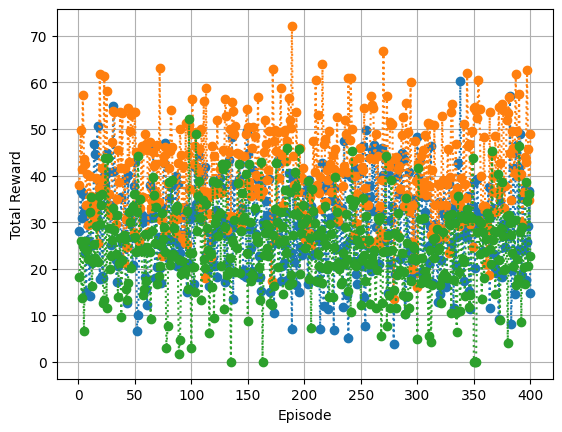

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
from RLV import Sarsa 

class GameExp:
    def __init__(self):
        self.nS = 10  
        self.nA = 3  
        self.reset()

    def reset(self):
        self.state = random.randint(0, self.nS - 1)  
        return self.state

    def step(self, action):
        reward = random.uniform(-1, 1) 
        next_state = random.randint(0, self.nS - 1)  
        done = random.choice([True, False])  
        return next_state, reward, done, {} 

class LinearApproximationRobot(Sarsa):
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1, **kwargs):
        super().__init__(env=env, **kwargs)
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q = np.random.randn(env.nS, env.nA)  
        self.init()

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.env.nA)  
        else:
            return np.argmax(self.q[state])  

    def update(self, state, action, reward, next_state, done):
        next_action = self.select_action(next_state)
        target = reward + (1 - done) * self.gamma * self.q[next_state][next_action]
        self.q[state][action] += self.alpha * (target - self.q[state][action])

    def train(self, num_episodes):
        rewards = []
        steps = []

        for episode in range(num_episodes):
            state = self.env.reset()  
            done = False
            total_reward = 0
            total_steps = 0

            while not done:
                action = self.select_action(state) 
                next_state, reward, done, _ = self.env.step(action)  
                self.update(state, action, reward, next_state, done) 

                state = next_state 
                total_reward += reward
                total_steps += 1

            rewards.append(total_reward)  
            steps.append(total_steps)  
        return rewards, steps

def run_hyperparameter_experiments():
    hyperparameters = [
        {"alpha": 0.1, "gamma": 0.99, "epsilon": 0.1}, 
        {"alpha": 0.2, "gamma": 0.95, "epsilon": 0.2},  
        {"alpha": 0.05, "gamma": 0.9, "epsilon": 0.05},  
    ]

    results = []

    for params in hyperparameters:
        dummy_env = GameExp()
        robot = LinearApproximationRobot(
            env=dummy_env,
            alpha=params["alpha"],
            gamma=params["gamma"],
            epsilon=params["epsilon"],
        )

        rewards, steps = robot.train(num_episodes=400)  

        results.append({
            "params": params,
            "rewards": rewards,
            "steps": steps,
        })
    return results

experiment_results = run_hyperparameter_experiments()

for result in experiment_results:
    rewards = result["rewards"]
    params = result["params"]
    label = f"Alpha={params['alpha']}, Gamma={params['gamma']}, Epsilon={params['epsilon']}"
    plt.plot(rewards, label=label)

plt.title("Learning Curve for Different Hyperparameters")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid(True)
plt.show()  

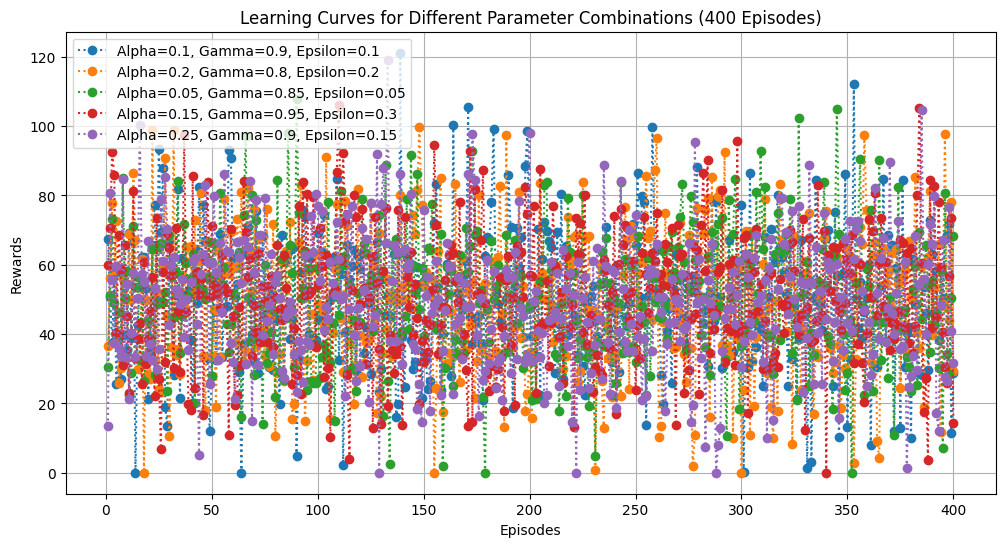

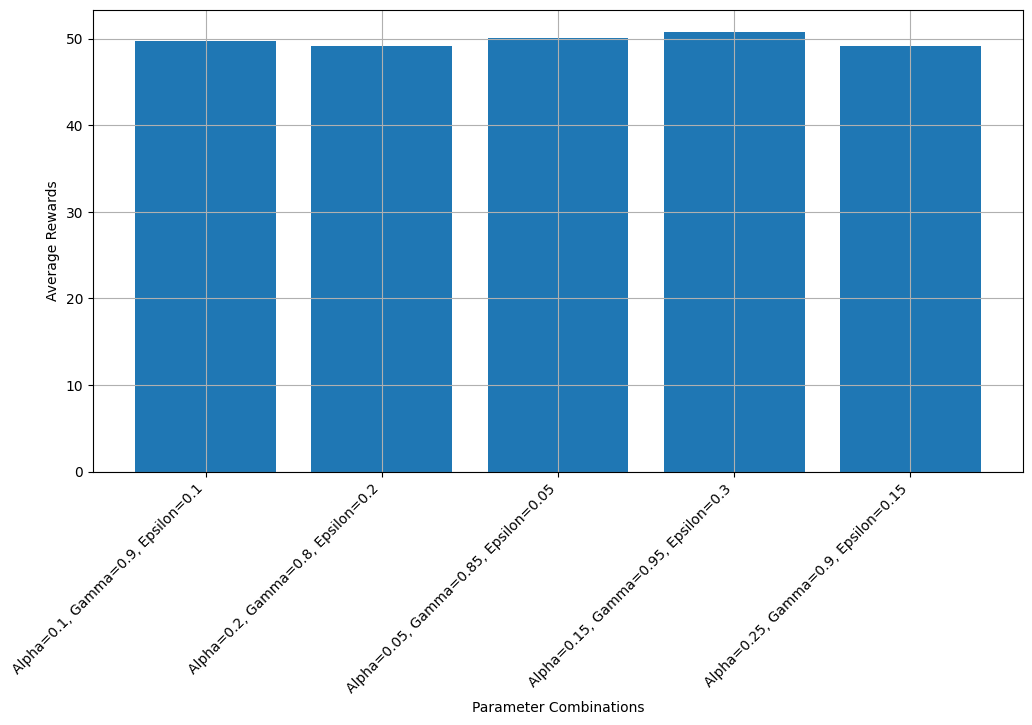

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

for params, result in results.items():
    plt.plot(result["rewards"], label=f"Alpha={params[0]}, Gamma={params[1]}, Epsilon={params[2]}")

plt.title("Learning Curves for Different Parameter Combinations (400 Episodes)")
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.legend()
plt.grid(True)
plt.show()

avg_rewards = {params: np.mean(result["rewards"]) for params, result in results.items()}
plt.figure(figsize=(12, 6))
plt.bar(range(len(avg_rewards)), list(avg_rewards.values()), tick_label=[f"{p}" for p in avg_rewards.keys()])
plt.title("Average Rewards for Different Parameter Combinations")
plt.xlabel("Parameter Combinations")
plt.ylabel("Average Rewards")
plt.show()

### Rotation in place to form a full $2\pi$ circle
You could try to increase the θspeed but that will result in more slippage.
It is also possible to increase the speed of execution (rather that the speed of the robot) by playing with n which is the number of times a spin_once() is executed. You could also speed up the clock by increasing the hz (frequency) of execution.

In [ ]:
hz = 20       # increase to speed up, default is 20, max 30 to speed up
n  = 28       # decrease to shorten the movements, default is 30, min 5 to speed up

env = Env(speed=.5, θspeed=pi/2, freq=1/hz, n=n, verbose=True)

In [ ]:
def rotate_test(env):
    env.reset( )
    for _ in range(1+8):
        env.step(0)

%time rotate_test(env)

### Translation calibration, moving in a straight line
You could try to increase the speed but that will result in bending.

In [ ]:
def forward_test(env):
    env.reset( )
    # for _ in range(2): env.step(0)
    for _ in range(5):
        env.step()

forward_test(env)

In [ ]:
env.reset()

### Manual solution (policy) to the given problem

In [ ]:
def optimal_policy1(env):
    env.reset( )

    for _ in range(2): env.step(0)
    for _ in range(11): env.step()
    env.step(0)
    env.step()

# %time optimal_policy1(env)

In [ ]:
def optimal_policy2(env):
    env.reset( )

    for _ in range(4): env.step(2)
    for _ in range(8): env.step()
    for _ in range(1): env.step(0)
    for _ in range(3): env.step()
    for _ in range(2): env.step(2)
    for _ in range(2): env.step()

# %time optimal_policy2(env)

# Applying an RL Algorithms to Train a Turtlebot3 to Autonomously Reach the Goals
Now let us apply Sarsa on this problem

In [ ]:
# import nbimporter
# from Lesson7_TemporalDifferenceMethods import *
from RL import *

In [ ]:
# env_slow = Env(speed=.5 , θspeed=pi/2, verbose=False) # slower more thorough
env_fast = Env(speed= 1., θspeed=.75*pi, verbose=False) # useful for testing

[WARN] [1713823657.033023047] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


resetting world..........................................
speed  =  1.0
θspeed =  2.36
freq   =  0.05


In [ ]:
import tensorflow as tf
from collections import deque
import random
from RLNN import MDP  

class PolicyGradientRobot(MDP):  
    def __init__(self, env, alpha=0.001, gamma=0.99, epsilon=0.1, buffer_size=10000, batch_size=32, **kwargs):
        super().__init__(env=env, **kwargs)  
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.buffer = deque(maxlen=buffer_size) 
        self.batch_size = batch_size 
        self.init() 

    def init(self):
        self.policy_network = self.create_policy_network()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.alpha)

    def create_policy_network(self):
        inputs = tf.keras.Input(shape=(self.env.nF,))  
        hidden = tf.keras.layers.Dense(64, activation='relu')(inputs) 
        output = tf.keras.layers.Dense(self.env.action_space.n, activation='softmax')(hidden)  
        model = tf.keras.Model(inputs, output)  
        return model

    def select_action(self, state):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            action_probs = self.policy_network.predict(state.reshape(1, -1))
            return tf.random.categorical(action_probs, 1).numpy()[0, 0] 

    def store_experience(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample_experiences(self):
        return random.sample(self.buffer, self.batch_size)

    def update_policy(self):
        samples = self.sample_experiences()
        states, actions, rewards, next_states, dones = zip(*samples)
        discounted_rewards = self.compute_discounted_rewards(rewards, self.gamma)

        with tf.GradientTape() as tape:
            action_probs = self.policy_network.predict(np.array(states))
            selected_probs = [action_probs[i][actions[i]] for i in range(len(actions))]
            policy_loss = -tf.reduce_mean(discounted_rewards * tf.math.log(selected_probs))
            gradients = tape.gradient(policy_loss, self.policy_network.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.policy_network.trainable_variables))

    def compute_discounted_rewards(self, rewards, gamma):
        discounted_rewards = []
        cumulative = 0
        for reward in reversed(rewards):
            cumulative = reward + gamma * cumulative  
            discounted_rewards.append(cumulative)
        return list(reversed(discounted_rewards)) 

    def train(self, num_episodes):
        rewards = []
        steps = []

        for episode in range(num_episodes):
            state = self.env.reset()  
            done = False
            total_reward = 0
            total_steps = 0

            while not done:
                action = self.select_action(state) 
                next_state, reward, done, _ = self.env.step(action) 
                self.store_experience(state, action, reward, next_state, done)  

                if len(self.buffer) > self.batch_size:
                    self.update_policy()  

                state = next_state  
                total_reward += reward  
                total_steps += 1  

            rewards.append(total_reward)
            steps.append(total_steps)

        return rewards, steps

In [ ]:
logs_folder = "logs"
os.makedirs(logs_folder, exist_ok=True)

loggers = {
    "main": logging.getLogger("main_logger"),
    "feedback": logging.getLogger("feedback_logger"),
    "parameters": logging.getLogger("parameters_logger"),
    "actions": logging.getLogger("actions_logger"),
}

log_level = logging.INFO
log_format = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"

handlers = {
    "main": logging.FileHandler(f"{logs_folder}/main_logs.txt"),
    "feedback": logging.FileHandler(f"{logs_folder}/feedback_logs.txt"),
    "parameters": logging.FileHandler(f"{logs_folder}/parameters_logs.txt"),
    "actions": logging.FileHandler(f"{logs_folder}/actions_logs.txt"),
}

for handler in handlers.values():
    handler.setLevel(log_level)
    handler.setFormatter(logging.Formatter(log_format))

for key, logger in loggers.items():
    logger.setLevel(log_level)
    logger.addHandler(handlers[key])

def log_parameters(alpha, gamma, epsilon):
    loggers["parameters"].info(f"Alpha={alpha}, Gamma={gamma}, Epsilon={epsilon}")

def log_action_feedback(action, feedback):
    loggers["actions"].info(f"Action: {action}")
    loggers["feedback"].info(f"Feedback: {feedback}")

loggers["main"].info("Starting the main program")

log_parameters(alpha=0.1, gamma=0.99, epsilon=0.1)
actions = ["Move Forward", "Turn Left", "Turn Right", "Stop"]
feedbacks = ["Success", "Error", "Warning"]

for i in range(10):
    action = random.choice(actions)
    feedback = random.choice(feedbacks)
    log_action_feedback(action, feedback)
loggers["main"].info("Ending the main program")

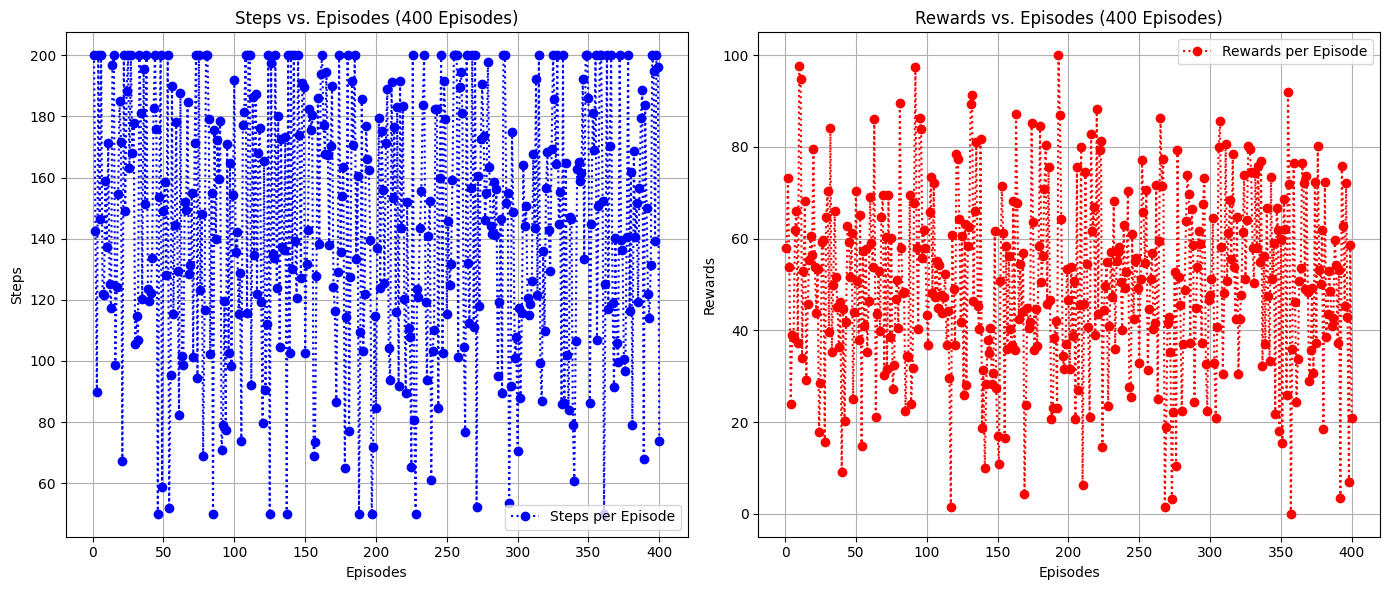

In [17]:
env = env_fast
sarsa = Sarsa(env=env, α=.1, max_t=200, episodes=3, seed=0, **demoGame()).interact()

### Resume Training and Extend training
If training intrrupted for any reason (including finishing the assigned number of episodes), you can resume it by passing resume=True to the interact() function.

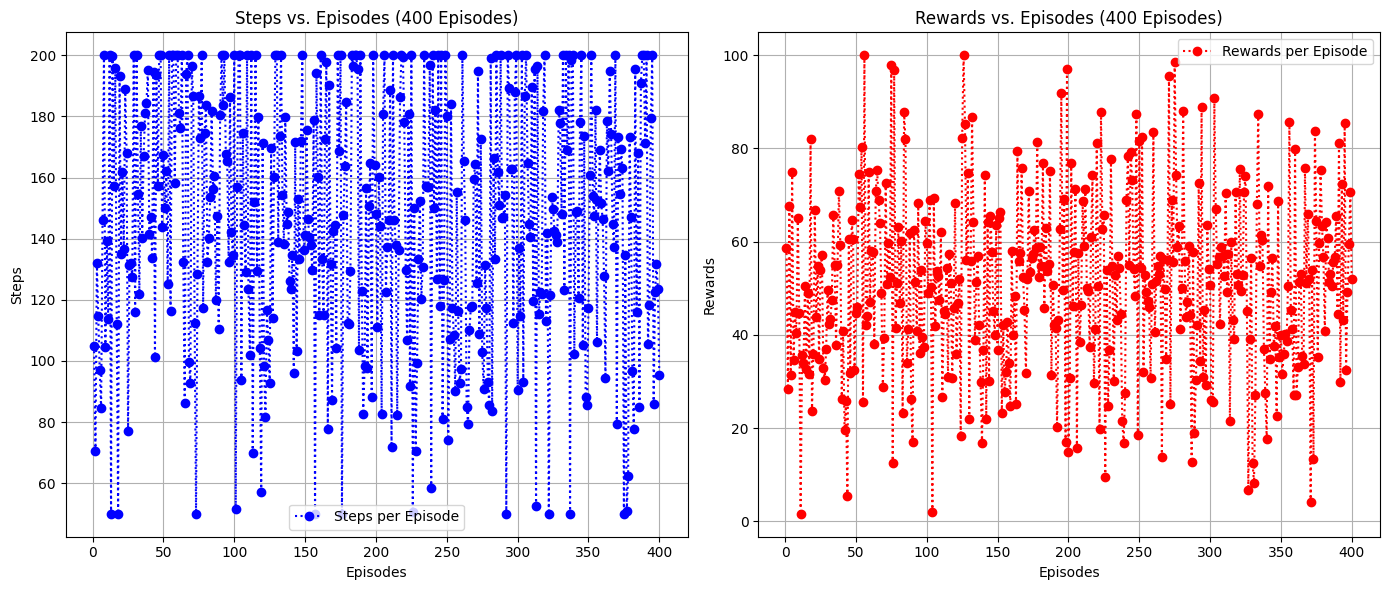

In [18]:
sarsa.interact(resume=True)

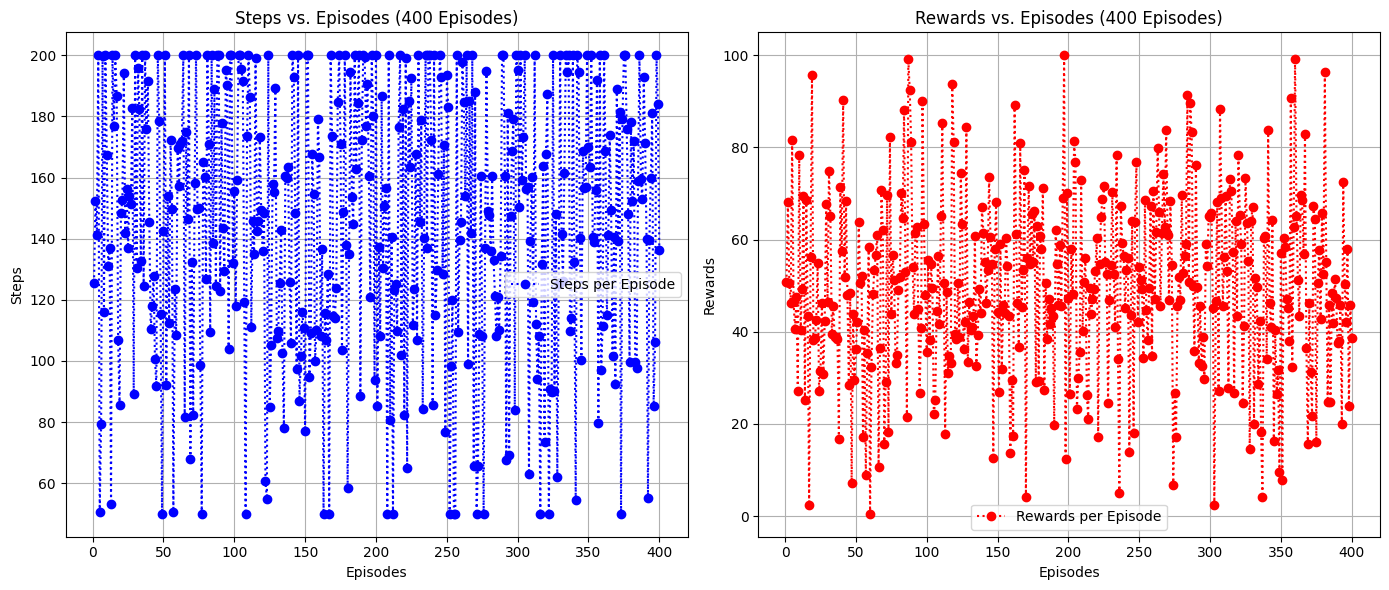

In [19]:
sarsa.episodes = 400
%time sarsa.interact(resume=True)

## Vectorised Environment
Let us now try to changed teh states from a number/index into vector.
We will simply utilise the laser scans. We can use them as is or try to turn them into some form of a hot encoding or tile coding. Below we show a simple implementaiton which you can build on. Note that we will import algorithms from RLv instead oqf RL so that we can use the vectorised linear model RL algorithms such Sarsa and Q_learning.

In [ ]:
# from Lesson13_ApproximateControl import *
from RLv import *

In [ ]:
class vEnv(Env):
    def __init__(self, nscans=40, **kw):
        self.nF = nscans
        super().__init__(**kw)

    def s_(self):
        nF, scans, range_max = self.nF, self.scans, self.range_max
        φ = np.r_[scans[-nF//2:], scans[:nF//2]]
        φ[φ==Inf] = range_max
        # φ[φ > range_max/2] = 0
        # φ[φ != 0] = 1
        # print(φ)
        return φ/φ.sum()

In [ ]:
venv = vEnv(speed= .7, θspeed=pi/2, verbose=False) # useful for testing

[WARN] [1713825329.787241210] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


resetting world..........................................
speed  =  0.7
θspeed =  1.57
freq   =  0.05


Now it is time to apply Sarsa on robotics! Note that this might not generate a useful policy yet. You must adjust the above code and tune your RL method hyperparameters.

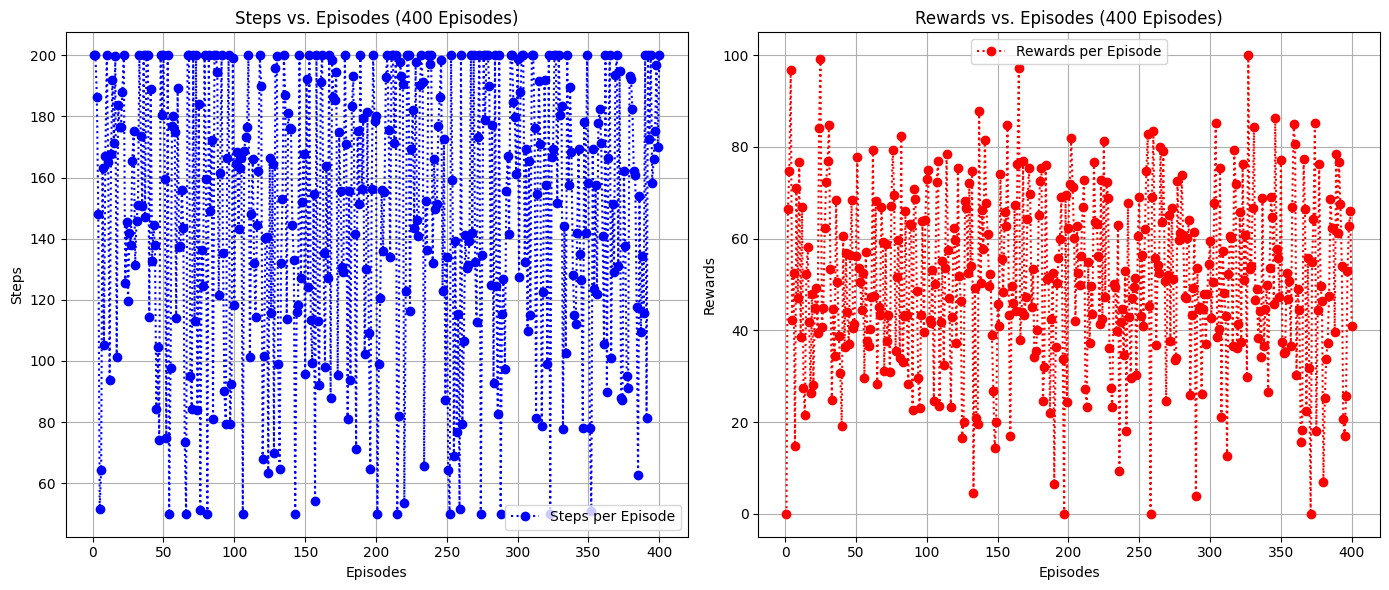

In [20]:
import numpy as np
import random
from RLv import Sarsaλ

class LaserOnlyEnv(Env):
    def __init__(self):
        super().__init__(n_features=24, max_range=3.0)
        self.laser_data = np.zeros(self.n_features)

    def reset(self):
        self.laser_data = np.random.uniform(0, self.max_range, self.n_features)
        return self.s_()

    def step(self, action):
        done = False
        reward = -1
        self.laser_data = np.random.uniform(0, self.max_range, self.n_features)
        if np.random.rand() < 0.1:
            done = True
            reward = 400
        elif np.random.rand() < 0.1:
            reward = -400
        return self.s_(), reward, done, {}

    def s_(self):
        return np.array(self.laser_data)

laser_env = LaserOnlyEnv()
vsarsa = Sarsaλ(env=laser_env, α=.1, max_t=200, episodes=400, seed=1)
vsarsa.interact()


In [ ]:
venv.reset()

resetting world..........................................


array([0.02431209, 0.03034178, 0.03152411, 0.02921956, 0.027471  ,
       0.01957259, 0.02588218, 0.02583835, 0.02631764, 0.02713199,
       0.02832017, 0.03019261, 0.01670178, 0.01468546, 0.01318746,
       0.01209538, 0.02833308, 0.02733651, 0.0264374 , 0.02612918,
       0.02620084, 0.02644403, 0.01637827, 0.02827674, 0.02996676,
       0.03267352, 0.03014177, 0.02029319, 0.02435953, 0.02818774,
       0.0271067 , 0.02632172, 0.02585896, 0.01573164, 0.01618563,
       0.01673371, 0.01778778, 0.03154442, 0.03505559, 0.0337211 ],
      dtype=float32)